# OSM data analysis of bars

This python notebook analyses bar data within Kathmandu. First, OSM data within a given geojson bounds is extracted using the `osmnx` package. After this, by making requests to the Overpass API, we look at the latest date at which each entity is modified. Finally, after joining these two datasets, we generate summary statisics and time series plots to understand attribute coverage and data recency.

In [1]:
import os
import numpy as np
import requests
import geopandas as gpd
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap


boundary_file = "kathmandu.geojson"
tags = {"amenity": "bar"}
filename = "bar"
completeness_tags = ["name", "opening_hours", "phone","email"]

In [2]:
kathmandu_valley = gpd.read_file(boundary_file)

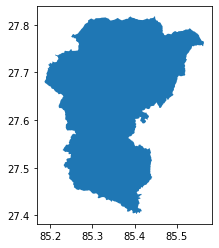

In [3]:
# create the plot
kathmandu_valley.plot()
north=kathmandu_valley.bounds['maxy'].values.item()
south=kathmandu_valley.bounds['miny'].values.item()
east=kathmandu_valley.bounds['maxx'].values.item()
west=kathmandu_valley.bounds['minx'].values.item()

In [4]:
osm_data=ox.geometries_from_bbox(north, south, east, west,tags)
timestamp = pd.DataFrame({'unique_id': [], 'timestamp': []})

entitylist = osm_data['unique_id'].to_list()
for entity in entitylist:
    index = entitylist.index(entity)
    overpass_url = "http://overpass-api.de/api/interpreter"
    feat_type = entity.split("/")[0]
    feat_id = entity.split("/")[1]
    query = f'[out:json][timeout:25];({feat_type}({feat_id}););out meta;'
    r = requests.get(overpass_url, params={'data': query})
    try:
        element = r.json()['elements'][0]
        timestamp = timestamp.append({'unique_id': entity, 'timestamp': element['timestamp']}, ignore_index=True)
        print(str(index) +" __ "+ str(entity) +" __ "+ element['timestamp'])
    except:
        print("Exception: " + str(entity))
        
del(osm_data["geometry"])
final = pd.merge(osm_data, timestamp, how='inner', on='unique_id')        
# final.to_csv(path_or_buf=filename, sep=",", index=False)

0 __ node/1892815646 __ 2015-02-15T17:17:02Z
1 __ node/2002392575 __ 2012-11-08T10:28:05Z
2 __ node/2684769719 __ 2014-02-22T09:31:13Z
3 __ node/3331703762 __ 2015-02-05T11:41:33Z
4 __ node/3416542473 __ 2020-11-27T21:04:25Z
5 __ node/3448046467 __ 2017-08-22T04:42:28Z
6 __ node/3605488689 __ 2015-06-19T16:02:25Z
7 __ node/4012267067 __ 2016-02-18T08:48:20Z
8 __ node/4104026289 __ 2016-04-19T16:43:08Z
9 __ node/4327597890 __ 2019-03-27T21:25:54Z
10 __ node/4477409493 __ 2016-11-02T18:04:34Z
11 __ node/4527629090 __ 2017-02-11T14:05:48Z
12 __ node/4555545492 __ 2016-12-15T13:45:31Z
13 __ node/4665021794 __ 2017-03-13T08:15:28Z
14 __ node/4675917591 __ 2017-02-09T05:27:10Z
15 __ node/4697090889 __ 2017-02-21T10:46:14Z
16 __ node/4762401054 __ 2017-03-29T17:34:06Z
17 __ node/4774872364 __ 2017-04-04T14:22:45Z
18 __ node/4774887621 __ 2017-04-04T14:10:59Z
19 __ node/4815643023 __ 2017-04-25T13:40:39Z
20 __ node/4830990522 __ 2018-11-21T07:09:35Z
21 __ node/4858983921 __ 2017-05-17T05:54:12

## Tag completeness

In this section, the entire OSM dataset is checked for completeness based on availability of the following standard tags (key value pairs) for hotels. In addition, a completeness score is also assigned for each individual entity based on the availaibility of the following tags.   

| Information     | Key           | Value             |
|-----------------|---------------|-------------------|
| Infrastructure  | amenity       | cafe              |
| Name            | name          | Name of hotel     |
| Opening hours   | opening_hours | Mo-Fr 10:00-17:00 |
| Phone           | phone         | Ph no.            |
| Email           | email         | email address     |


In [5]:
completeness = pd.DataFrame({'tag': [], 'completeness_percentage': []})

total_entries = len(final)
for tag in completeness_tags:
    if tag in final.columns:
        nulls = final[tag].isna().sum()  
        completeness = completeness.append({'tag': tag,'completeness_percentage': ((total_entries - nulls)/total_entries)*100}, ignore_index=True)
    else:
        completeness = completeness.append({'tag': tag,'completeness_percentage': 0.0 }, ignore_index=True)
        

/home/arogya/projects/c2m2/osm_analysis/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<BarContainer object of 4 artists>

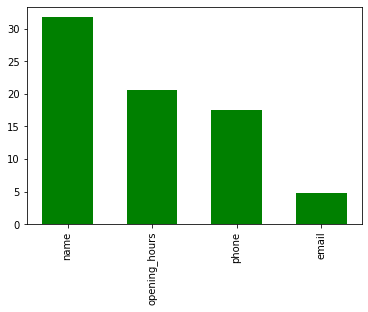

In [6]:
import matplotlib.pyplot as plt 
x = completeness.tag
y = completeness.completeness_percentage

plt.xticks(rotation=90) 
plt.bar(x, y, tick_label = x, 
        width = 0.6, color = [ 'green'])

In [7]:
completeness_scores =  pd.DataFrame({'unique_id': [], 'completeness_score': []})
for index, row in final.iterrows():
    total_tags = len(completeness_tags)
    count = 0
    
    for tag in completeness_tags:
        if tag in final.columns:
            if row[tag] is None:
                count = count
            else:
                count = count + 1
    completeness_scores = completeness_scores.append({'unique_id': row.unique_id, 'completeness_score': count/total_tags}, ignore_index=True)

final = pd.merge(final, completeness_scores, how='inner', on='unique_id')        
final.to_csv(path_or_buf=filename+".csv", sep=",", index=False)
completeness.to_csv(path_or_buf=filename+"_completeness.csv", sep=",", index=False)

## Data recency

In this section, the entire OSM dataset is checked for recency.

<BarContainer object of 36 artists>

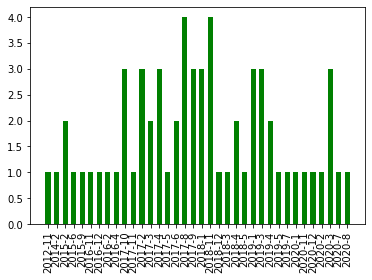

In [8]:
final.timestamp = pd.to_datetime(final.timestamp)
final['YearMonth'] =final['timestamp'].apply(lambda x: '{year}-{month}'.format(year=x.year, month=x.month))
# final.groupby('YearMonth')
counts = final.value_counts(subset=['YearMonth']).rename_axis('unique_values').reset_index(name='counts')
counts = counts.sort_values(by="unique_values")
counts.to_csv(path_or_buf=filename+"_counts.csv", sep=",", index=False)

x = counts.unique_values
y = counts.counts

plt.xticks(rotation=90) 
plt.bar(x, y, tick_label = x, 
        width = 0.6, color = [ 'green'])

<BarContainer object of 8 artists>

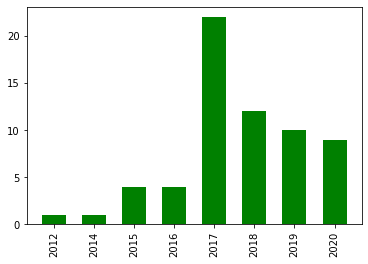

In [9]:
final.timestamp = pd.to_datetime(final.timestamp)
final['Year'] = final['timestamp'].apply(lambda x: '{year}'.format(year=x.year))
# final.groupby('YearMonth')

year_counts = final.value_counts(subset=['Year']).rename_axis('unique_values').reset_index(name='counts')
year_counts = year_counts.sort_values(by="unique_values")


x = year_counts.unique_values
y = year_counts.counts


plt.xticks(rotation=90) 
plt.bar(x, y, tick_label = x, 
        width = 0.6, color = [ 'green'])